In [1]:
import pyspark
from pyspark.sql import SparkSession
from glob import glob
from pyspark.sql import functions
from pyspark.sql.functions import input_file_name, substring, regexp_extract, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
%config IPCompleter.greedy=True

In [2]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from glob import glob

from pyspark.sql.types import StructType, StructField, StringType, DoubleType, TimestampType
from pyspark.sql import functions
from pyspark.sql.functions import input_file_name, substring, regexp_extract, col
import pandas as pd
import ast
import re

from pyspark.sql.functions import col
spark = SparkSession.builder\
         .master("local")\
         .appName("StockPrediction")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/08 21:25:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
schema = StructType([StructField("date",TimestampType(),True),
                     StructField("open",DoubleType(),True),
                     StructField("high",DoubleType(),True),
                     StructField("low",DoubleType(),True),
                     StructField("close",DoubleType(),True),
                     StructField("volume",DoubleType(),True)])

In [4]:
path = "/Users/d0d02tr/Desktop/hourly-data/*.txt"
Stock_DataPath = path

In [5]:
stock_df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .schema(schema) \
    .json(Stock_DataPath) \
    .withColumn("company", regexp_extract(input_file_name(), "/([^/]+)$", 1))




**Read data into Dataframe with file names also as an**

In [6]:
stock_df.show()

+-------------------+------+------+------+------+------+--------------------+
|               date|  open|  high|   low| close|volume|             company|
+-------------------+------+------+------+------+------+--------------------+
|2022-10-06 09:15:00| 240.5| 242.0| 236.8| 239.0|2093.0|SREELEATHERS._hou...|
|2022-10-06 10:15:00| 239.0| 240.7| 238.1| 238.1|2340.0|SREELEATHERS._hou...|
|2022-10-06 11:15:00| 238.1|238.75| 238.1| 238.1| 541.0|SREELEATHERS._hou...|
|2022-10-06 12:15:00| 238.1| 238.1| 233.4| 234.3|1386.0|SREELEATHERS._hou...|
|2022-10-06 13:15:00| 234.3| 237.2|233.05| 237.2| 629.0|SREELEATHERS._hou...|
|2022-10-06 14:15:00| 237.2| 237.2| 230.0| 232.0| 759.0|SREELEATHERS._hou...|
|2022-10-06 15:15:00| 232.0| 232.1|228.95| 231.3| 575.0|SREELEATHERS._hou...|
|2022-10-07 09:15:00|230.65| 233.3| 224.6|229.85| 748.0|SREELEATHERS._hou...|
|2022-10-07 10:15:00|229.85|229.85|229.85|229.85|   0.0|SREELEATHERS._hou...|
|2022-10-07 11:15:00|229.85|229.85|229.85|229.85|   0.0|SREELEAT

In [7]:
stock_df = stock_df.withColumn('symbol', functions.split('company', '_hourly')[0]).withColumn('symbol', functions.expr("replace(symbol, '%20', ' ')"))

In [8]:
stock_df.select('symbol').distinct().show(truncate= False)

OpenJDK 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
OpenJDK 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=29900Kb max_used=29900Kb free=101171Kb
 bounds [0x0000000103d4c000, 0x0000000105abc000, 0x000000010bd4c000]
 total_blobs=11525 nmethods=10605 adapters=833
 compilation: disabled (not enough contiguous free space left)


+------------------------------+
|symbol                        |
+------------------------------+
|KHANDWALA SECURITIES.         |
|PAGE INDUSTRIES.              |
|SIEMENS.                      |
|SSPDL.                        |
|PIRAMAL ENTERPRISES.          |
|3M INDIA.                     |
|KOTAK MAHINDRA BANK.          |
|STERLING GREEN WOODS.         |
|LARSEN _ TOUBRO.              |
|SENSEX                        |
|TATA CONSULTANCY SERVICES.    |
|TITAN COMPANY                 |
|NESTLE INDIA.                 |
|HINDUSTAN UNILEVER.           |
|HDFC BANK.                    |
|RELIANCE INDUSTRIES.          |
|SHRIRAM FINANCE               |
|PROCTER _ GAMBLE HYGIENE _ HEA|
|INFOSYS.                      |
|INTERGLOBE AVIATION           |
+------------------------------+
only showing top 20 rows



In [9]:
aggregated_stock_df = stock_df.groupby('symbol').agg(
    F.avg("open").alias("avg_open"),
    F.avg("high").alias("avg_high"),
    F.avg("low").alias("avg_low"),
    F.avg("close").alias("avg_close"),
    F.avg("volume").alias("avg_volume"))

In [10]:
aggregated_stock_df.show(truncate= False)
aggregated_stock_df.count()

+------------------------------+------------------+------------------+------------------+------------------+------------------+
|symbol                        |avg_open          |avg_high          |avg_low           |avg_close         |avg_volume        |
+------------------------------+------------------+------------------+------------------+------------------+------------------+
|KHANDWALA SECURITIES.         |23.123167475728433|23.279808625840488|22.926632748319957|23.112325429425248|742.3238424197162 |
|PAGE INDUSTRIES.              |31595.975080004675|31732.217577337702|31451.851665283935|31589.243996681245|245.8514874955553 |
|SIEMENS.                      |2085.4645988861216|2094.5099597108665|2076.1769166963068|2085.205284986375 |3486.6250740609075|
|SSPDL.                        |17.370127317399934|17.5089122180031  |17.2129357456629  |17.35971632789803 |407.1853175489539 |
|PIRAMAL ENTERPRISES.          |1538.9245466398004|1548.4714827545315|1528.9527734976887|1538.2947493184

2441

In [11]:
aggregated_stock_df.printSchema()

root
 |-- symbol: string (nullable = true)
 |-- avg_open: double (nullable = true)
 |-- avg_high: double (nullable = true)
 |-- avg_low: double (nullable = true)
 |-- avg_close: double (nullable = true)
 |-- avg_volume: double (nullable = true)



In [12]:
feature_columns = ['avg_open', 'avg_high', 'avg_low', 'avg_close', 'avg_volume']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
assembled_data = assembler.transform(aggregated_stock_df)
k = 5
kmeans = KMeans(k=k, seed=1, featuresCol='features', predictionCol='cluster')
model = kmeans.fit(assembled_data)
predictions = model.transform(assembled_data)
predictions.select('symbol', 'features', 'cluster').orderBy('cluster').show(100,truncate=False)

23/12/08 21:32:44 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+------------------------------+------------------------------------------------------------------------------------------------+-------+
|symbol                        |features                                                                                        |cluster|
+------------------------------+------------------------------------------------------------------------------------------------+-------+
|TEAMLEASE SERVICES            |[2917.773406398108,2934.1249763033034,2900.366250000024,2916.4482582938426,433.9776066350711]   |0      |
|PRESTIGE ESTATES PROJECTS.    |[365.19814507526434,367.6916202441636,362.77072419106446,365.1577337916327,6921.999288846747]   |0      |
|TRENT.                        |[943.0122260395684,948.319251273558,937.6276211349244,942.9029380405149,4315.02298305888]       |0      |
|IPCA LABORATORIES.            |[838.7790490870289,843.0451683661411,834.2835843016333,838.5851671804602,3833.8030590467156]    |0      |
|SIEMENS.                      |[2

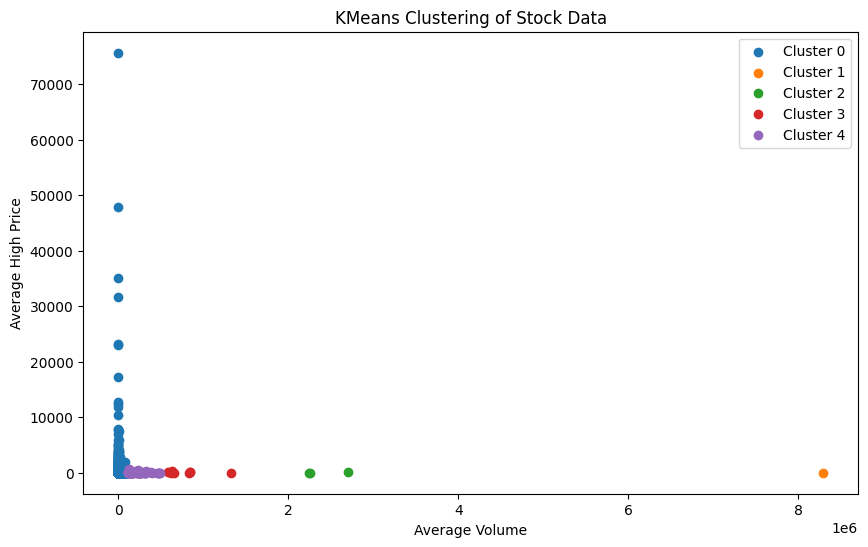

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert Spark DataFrame to Pandas for easy plotting
pd_predictions = predictions.select('symbol', 'avg_volume', 'avg_high', 'cluster').toPandas()

# Scatter plot with color-coded clusters
plt.figure(figsize=(10, 6))
for cluster_num in range(k):
    cluster_data = pd_predictions[pd_predictions['cluster'] == cluster_num]
    plt.scatter(cluster_data['avg_volume'], cluster_data['avg_high'], label=f'Cluster {cluster_num}')

plt.title('KMeans Clustering of Stock Data')
plt.xlabel('Average Volume')
plt.ylabel('Average High Price')
plt.legend()
plt.show()

In [14]:
from pyspark.sql import Window
from pyspark.sql.functions import row_number, desc

prediction_df = predictions.withColumn("metric", col('avg_high') - col('avg_low'))

prediction_df.printSchema()


# Assuming 'prediction_df' is your DataFrame
# Create a Spark session if not already created
# spark = SparkSession.builder.appName("TopSymbolsByCluster").getOrCreate()

# Define a window specification to partition by cluster and order by metric
window_spec = Window.partitionBy('cluster').orderBy(desc('metric'))

# Add a row number to each row within the window specification
ranked_predictions = prediction_df.withColumn('row_num', row_number().over(window_spec))

# Select the top 5 symbols from each cluster
top_symbols_per_cluster = ranked_predictions.filter('row_num <= 2').select('symbol', 'cluster', 'metric')

# Show the result
top_symbols_per_cluster.show(truncate=False)


root
 |-- symbol: string (nullable = true)
 |-- avg_open: double (nullable = true)
 |-- avg_high: double (nullable = true)
 |-- avg_low: double (nullable = true)
 |-- avg_close: double (nullable = true)
 |-- avg_volume: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- cluster: integer (nullable = false)
 |-- metric: double (nullable = true)



+------------------------------+-------+------------------+
|symbol                        |cluster|metric            |
+------------------------------+-------+------------------+
|MRF.                          |0      |519.0132171641453 |
|HONEYWELL AUTOMATION INDIA    |0      |286.7433060589683 |
|VODAFONE IDEA                 |1      |0.1778586672989313|
|YES BANK.                     |2      |0.7005248193342339|
|JAIPRAKASH POWER VENTURES LIMI|2      |0.0778125741400233|
|JIO FINANCIAL SERVICES        |3      |2.5436363636362955|
|ZOMATO                        |3      |1.2262200000007795|
|ICICI BANK.                   |4      |4.945269148690386 |
|INDIABULLS HOUSING FINANCE    |4      |4.694245227082405 |
+------------------------------+-------+------------------+

